# universal estimator-exp-1d (std < 1e-12)

**Results**:

STD < 1e-8
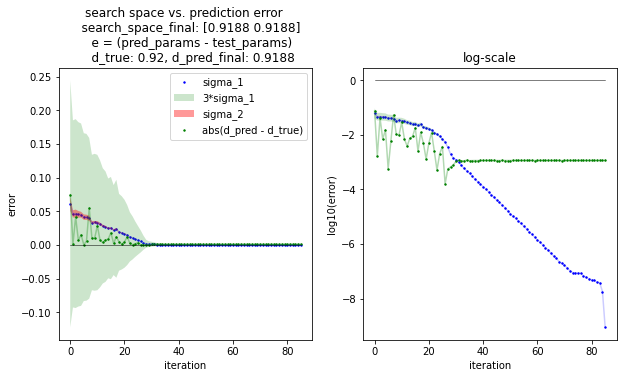

STD < 1e-10
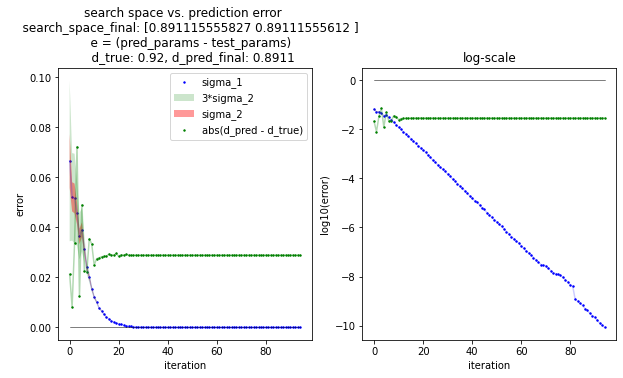

STD < 1e-12
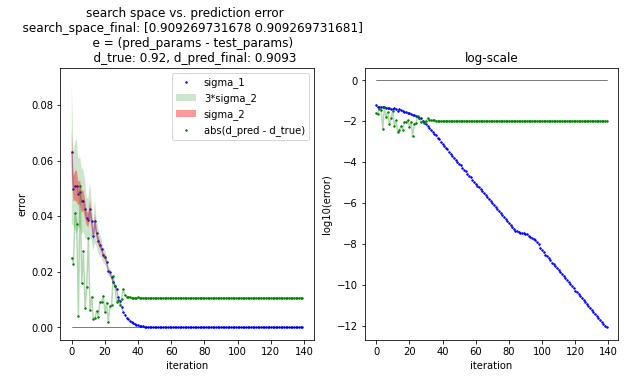

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=12)

In [2]:
from scipy import stats
from scipy.stats import lognorm
from scipy.stats import yulesimon

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

# sample from yulesimon
def sample_yulesimon(config, size):
    return yulesimon.rvs(alpha=config, size=size, random_state=RANDOM_STATE)

def next_config(search_space, loc=-1, scale=-1):

    """
    return a (uniform/normal) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    if loc < 0:
        return np.random.uniform(low, high, size=1)[0]
    
    param = np.random.normal(loc=loc, scale=scale, size=1)[0]

    # adjust from left
    param_adjusted = max(search_space[0], param)
    param_adjusted = max(0.01, param)
    
    # adjust from right
    param_adjusted = min(param_adjusted, search_space[1])
    
    return param_adjusted

In [3]:
# def MAE(e, axis=-1):
#     """mean absolute error"""
#     return np.mean(np.abs(e), axis=axis)

NUM_BINS = 346

def predict_d(f, sample, d_true, search_space, num_trials=1, N=1000, search_pivot=-1, search_scale=-1):
    
    """
    Learn parameters of f, from sample.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - sample: generated using f.
    """

    # number of observations in sample
    M = len(sample)
    N = N

    nbins = NUM_BINS
    
    # Generate a histogram for the input *sample*
    H_sample = np.histogram(sample, bins=nbins, range=(0,nbins), density=False)[0]
    H_sample = np.reshape(H_sample, (1, -1))
    
    # Iterate   
    d_pred_array = np.zeros(num_trials)
    for trial_idx in range(num_trials):

        # 1. Generate synthetic data-sets (train/test) using f (within search_space)
        # -----------------------------------------------------------------------------------------------
        print()
        print(f'*** search_space: {search_space}')
        print(f'generating data (M={M}, N={N})', end=', ')

        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(
                                           search_space, 
                                           loc=search_pivot, 
                                           scale=search_scale),
                                       nbins=nbins,
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)

        # 2. Fit a DNN model to train-set and predict on test-set
        # -----------------------------------------------------------------------------------------------

        # train
        print(f'training ...', end=' ')
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)

        # predict test
        pred_params = dnn_model.predict(H_test).flatten()

        # error
        e = pred_params - test_params

        # 3. Predict the parameter (d_pred) on the input sample
        # -----------------------------------------------------------------------------------------------

        d_pred = dnn_model.predict(H_sample).flatten()[0]
        d_pred_array[trial_idx] = d_pred
        
        print(f'STD(test): {np.std(e)}')

    return d_pred_array, test_params, pred_params

In [4]:
def estimator_exp_1(f, sample, d_true, initial_search_space):

    # experiment results
    res = {
        'search_space': [],
        'test_params': [],
        'pred_params': [],
        'd_true': d_true,
        'd_pred': [],
    }

    initial_search_space_width = initial_search_space[1] - initial_search_space[0]
    search_space = initial_search_space
    
    # Iterate
    it = 0
    search_pivot = -1
    search_scale = -1
    
    while True:
        
        it += 1
        
        num_trials = 1
        
        d_pred_array, test_params, pred_params = predict_d(f, 
                                                           sample, 
                                                           d_true, 
                                                           search_space, 
                                                           num_trials=num_trials, 
                                                           N=1000, 
#                                                            search_pivot=search_pivot, 
#                                                            search_scale=search_scale)
                                                           search_pivot=-1, 
                                                           search_scale=-1)
        
        d_pred = np.mean(d_pred_array)

        if len(d_pred_array) > 1:
            print(f'avg(d_pred): {d_pred:.4f}', end=', ')
        else:
            print(f'd_pred: {d_pred:.4f}', end=', ')
        print(f'abs_error: {abs(d_pred - d_true)}')
        
        # save results
        res['search_space'].append(search_space)
        res['test_params'].append(test_params)
        res['pred_params'].append(pred_params)
        res['d_pred'].append(d_pred)
        
        # update the search_space
        # ------------------------

        search_pivot = d_pred
        search_STD = np.std(pred_params - test_params)

#         std_factor = 1
#         std_factor = 2
        std_factor = 3

        search_scale = std_factor * search_STD
        print(f'search_pivot: {search_pivot:.4f}, search_scale ({std_factor}*STD) = {search_scale}')
        
        next_search_space = np.array([ 
            max(search_space[0], search_pivot - search_scale), 
            min(search_space[1], search_pivot + search_scale)])
        
        # if no change in search_space, narrow by epsilon
        if np.array_equal(search_space, next_search_space):

            epsilon = min(0.003, 0.1 * (search_space[1] - search_space[0]))
            print(f'no change in search_space. narrowing by epsilon: {epsilon}')
            next_search_space = np.array([ search_space[0] + epsilon, search_space[1] - epsilon ])
            search_space = next_search_space
        else:
            next_search_space_width = next_search_space[1] - next_search_space[0]
            if (next_search_space_width <= 0):
                epsilon = 0.1 * (search_space[1] - search_space[0])
                next_search_space = np.array([ search_space[0] + epsilon, search_space[1] - epsilon ])
            search_space = next_search_space

        # stop condition (2): search_STD <= 0.01
        if search_STD <= 1e-12:
            break

    res['search_space'] = np.array(res['search_space'])
    res['test_params'] = np.array(res['test_params'])
    res['pred_params'] = np.array(res['pred_params'])
    res['d_pred'] = np.array(res['d_pred'])
    
    return res

## Plot

In [5]:
def plot_search_space_size_vs_d_pred_error(res):

    search_space = res['search_space']
    search_space_width = search_space[:,1] - search_space[:,0]
    search_space_final = search_space[-1]
    
    d_true = res['d_true']
    d_pred = res['d_pred']
    d_pred_final = d_pred[-1] # d_pred of the last (narrowest) search_space
    d_pred_abs_error = np.abs(d_pred - d_true)

    pred_params = res['pred_params']
    test_params = res['test_params']

    # errors in each iteration
    e = pred_params - test_params
    
    # num-iterations
    n = e.shape[0]
    
    # avg error of each iteration
    mu = np.mean(e, axis=1).reshape((n,-1))
    
    # STD in each iteration
    sigma_1 = np.std(e, axis=1)

    # sigma_2
    mu = np.mean(e, axis=1).reshape(n, 1)
    var_2 = 1/n * np.sum(np.square(np.square(e - mu) - np.square(sigma_1).reshape(n,1)), axis=1)
    sigma_2 = np.sqrt(var_2)

    # iteration number
    x = np.array(range(n))
    
    # PLOT
    title = f'search space vs. prediction error \n\
    search_space_final: {search_space_final} \n\
    e = (pred_params - test_params) \n\
    d_true: {d_true}, d_pred_final: {d_pred_final:.4f}'
    
    fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    for ax in axes:

        # zero reference line
        ax.plot(x, np.zeros(n), zorder=2, c='black', linewidth=0.5)

        ax.set_xlabel('iteration')
        
        if ax == axes[0]:
            ax.set_title(title)
            y1 = sigma_1
            y2 = d_pred_abs_error
            ax.set_ylabel('error')
        else:
            ax.set_title('log-scale')
            y1 = np.log10(y1)
            y2 = np.log10(y2)
            ax.set_ylabel('log10(error)')

        ax.scatter(x, y1, zorder=1, s=2, c='blue', label='sigma_1')
        ax.plot(x, y1, zorder=2, c='blue', alpha=0.2)
        
        # confidence_interval_1: sigma_1 +- 3*sigma_2
        ax.fill_between(range(len(x)), 
                         y1 - 3*sigma_2, y1 + 3*sigma_2, 
                         facecolor='green', alpha=0.2, label='3*sigma_2')

        # confidence_interval_2: sigma_1 +- sigma_2
        ax.fill_between(range(len(x)), 
                         y1 - sigma_2, y1 + sigma_2, 
                         facecolor='red', alpha=0.4, label='sigma_2')

        # y2 (d_pred)
        ax.scatter(x, y2, zorder=1, s=2, c='green', label='abs(d_pred - d_true)')
        ax.plot(x, y2, zorder=2, c='green', alpha=0.3)
    
        if ax == axes[0]:
            ax.legend(loc='upper right')
            
    plt.show()

## Fit (lognormal)


param true value: 0.92

*** search_space: [0. 1.]
generating data (M=256, N=1000), training ... STD(test): 0.06308552599396414
d_pred: 0.9450, abs_error: 0.025036888122558554
search_pivot: 0.9450, search_scale (3*STD) = 0.1892565779818924

*** search_space: [0.755780310141 1.            ]
generating data (M=256, N=1000), training ... STD(test): 0.04983312685741883
d_pred: 0.9430, abs_error: 0.02296020269393917
search_pivot: 0.9430, search_scale (3*STD) = 0.14949938057225648

*** search_space: [0.793460822122 1.            ]
generating data (M=256, N=1000), training ... STD(test): 0.050913775190612715
d_pred: 0.8790, abs_error: 0.040974838733673136
search_pivot: 0.8790, search_scale (3*STD) = 0.15274132557183814
no change in search_space. narrowing by epsilon: 0.003

*** search_space: [0.796460822122 0.997         ]
generating data (M=256, N=1000), training ... STD(test): 0.05079119001138424
d_pred: 0.9573, abs_error: 0.03725560188293453
search_pivot: 0.9573, search_scale (3*STD) = 0.1

generating data (M=256, N=1000), training ... STD(test): 0.00952293105355439
d_pred: 0.9118, abs_error: 0.00824455738067631
search_pivot: 0.9118, search_scale (3*STD) = 0.028568793160663172
no change in search_space. narrowing by epsilon: 0.003

*** search_space: [0.89653937621 0.922        ]
generating data (M=256, N=1000), training ... STD(test): 0.007421446883820357
d_pred: 0.9098, abs_error: 0.010162098407745401
search_pivot: 0.9098, search_scale (3*STD) = 0.022264340651461073
no change in search_space. narrowing by epsilon: 0.0025460623790071303

*** search_space: [0.899085438589 0.919453937621]
generating data (M=256, N=1000), training ... STD(test): 0.005642850761804127
d_pred: 0.9062, abs_error: 0.013755781650543253
search_pivot: 0.9062, search_scale (3*STD) = 0.01692855228541238
no change in search_space. narrowing by epsilon: 0.0020368499032057063

*** search_space: [0.901122288492 0.917417087718]
generating data (M=256, N=1000), training ... STD(test): 0.004579500857312834
d

generating data (M=256, N=1000), training ... STD(test): 8.439746469629402e-08
d_pred: 0.9093, abs_error: 0.010730249881744425
search_pivot: 0.9093, search_scale (3*STD) = 2.531923940888821e-07
no change in search_space. narrowing by epsilon: 2.9070893248217544e-08

*** search_space: [0.909269571821 0.909269804389]
generating data (M=256, N=1000), training ... STD(test): 6.876519936734775e-08
d_pred: 0.9093, abs_error: 0.010730249881744425
search_pivot: 0.9093, search_scale (3*STD) = 2.0629559810204323e-07
no change in search_space. narrowing by epsilon: 2.3256714598574036e-08

*** search_space: [0.909269595078 0.909269781132]
generating data (M=256, N=1000), training ... STD(test): 5.368930517207199e-08
d_pred: 0.9093, abs_error: 0.010730249881744425
search_pivot: 0.9093, search_scale (3*STD) = 1.6106791551621598e-07
no change in search_space. narrowing by epsilon: 1.8605371687741012e-08

*** search_space: [0.909269613683 0.909269762526]
generating data (M=256, N=1000), training ... S

generating data (M=256, N=1000), training ... STD(test): 2.1027179214107957e-10
d_pred: 0.9093, abs_error: 0.01073019027709965
search_pivot: 0.9093, search_scale (3*STD) = 6.308153764232388e-10

*** search_space: [0.909269731376 0.909269731983]
generating data (M=256, N=1000), training ... STD(test): 1.6859790913789227e-10
d_pred: 0.9093, abs_error: 0.010731561183929483
search_pivot: 0.9093, search_scale (3*STD) = 5.057937274136768e-10

*** search_space: [0.909269731437 0.909269731923]
generating data (M=256, N=1000), training ... STD(test): 1.3299098291950116e-10
d_pred: 0.9093, abs_error: 0.01073019027709965
search_pivot: 0.9093, search_scale (3*STD) = 3.9897294875850347e-10

*** search_space: [0.909269731486 0.909269731874]
generating data (M=256, N=1000), training ... STD(test): 1.1337631608935344e-10
d_pred: 0.9093, abs_error: 0.01073019027709965
search_pivot: 0.9093, search_scale (3*STD) = 3.401289482680603e-10

*** search_space: [0.909269731524 0.909269731835]
generating data (M

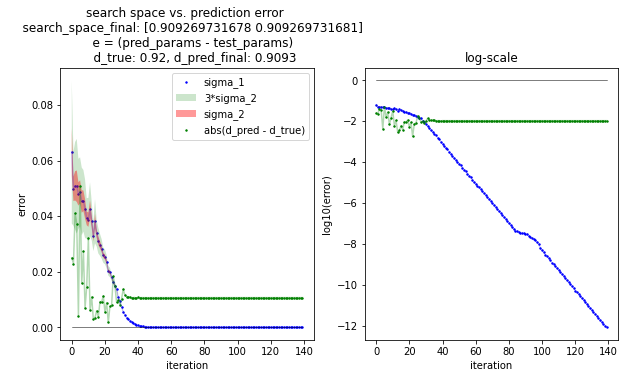

In [6]:
d_true  = 0.92
print()
print(f'param true value: {d_true}')
f = sample_lognormal
sample = f(config=d_true, size=256)
initial_search_space=np.array([0.0, 1.0])
res = estimator_exp_1(f=f, sample=sample, d_true=d_true, initial_search_space=initial_search_space)
plot_search_space_size_vs_d_pred_error(res)

In [7]:
# np.abs(res['pred_params'][-1] - res['test_params'][-1])
res['pred_params'][-1]

array([0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698, 0.9092698,
       0.9092698, 0.9092698, 0.9092698, 0.9092698, 